# AGT Challenge

The task at hand is a multi-class classification problem, for which both a training and a test (validation) set are provided as csv files, 'train.csv' and 'test.csv' accordingly.
What we ask is that you work on this classification task by building a classifier using only the training data, with the goal of achieving the best performance possible on the test data, classifying as correctly as possible the 'label' variable.


## Introduction

The goal of this script is to predict the label of the unseen data, i.e., test data, by using machine learning methods. In the following section, I will go through the following steps:
- Reading the dataset
- Generating training, test, and validation sets
- Cleaning the data
    - converting string values to integer values
    - replacing the missing features 
    - standardization of the features
- Training an SVM and evaluating the classification accuracy with all the given features
- Applying Principal Component Analysis (PCA) to reduce the dimensionality of the features
- Trainng an SVM on the dimensionality reduced features and evaluating the classification accuracy 

### Import libraries

In [13]:
from __future__ import division
from csv import reader
import numpy as np
from sklearn import preprocessing, svm
from sklearn.feature_selection import SelectFromModel
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import matplotlib.pyplot as plt

## Reading dataset and cleaning data

In [2]:
# This function is used for loading data from a CSV file.
def load_csv(filename):
    """
    Load data from csv file.
    :param filename: csv file path
    :return: data matrix
    """
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)

    return np.array(dataset)

# This function splits data into two parts.
# A number of percentage is used to indicate how much data is put into the first part.
def split_data(X, y, per=0.1):
    """
    Separated data into two parts with the specified percentage.
    :param X: features
    :param y: label
    :param per: percentage
    :return: the separated data
    """
    length = int(len(X) * per)

    return X[0:length, :], y[0:length], X[length:, :], y[length:]

These functions are used to convert string values into integer values.

In [3]:
# This function tests if a given value is a number or not.
def is_number(s):
    return is_int(s) or is_float(s)

def is_int(s):
    try:
        int(s)
        return True
    except ValueError:
        return False


def is_float(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    

# This function extracts the indices of columns where the values in the columns are string.
def get_str_column_indices(row):
    """
    Get the indices of columns which contain only string values.
    :param row: data row
    :return: column indices
    """
    column_indices = []
    for i, value in enumerate(row):
        if not is_number(value):
            column_indices.append(i)
    
    return column_indices

# This function converts string values into integer values.
def str_column_to_int(dataset, column):
    """
    For each column of a matrix (dataset), change string values to integer values.
    :param dataset: data matrix
    :param column: column index
    :return: a dictionary
    """
    values = [row[column] for row in dataset]
    unique = set(values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
    for row in dataset:
        row[column] = lookup[row[column]]
    
    return lookup

#### The next function first loads data from a CSV file. Then it cleans the data by applying the following steps:
    - Removing the header of the content.
    - Removing the first and second columns, since they only contain the numbers of samples. The number is not useful for classification.
    - Dividing the data into X(features) and y(labels).
    - Converting string values in X into integer values.

In [4]:
def load_data(train_filename, shuffle=False):
    """
    Load data from csv file. Then clean up the data.
    :param filename: csv file path
    :return: X (features), y (labels)
    """
    
    # read data from csv
    dataset = load_csv(filename)

    # remove header, the first, and second columns
    dataset = dataset[1:, 2:]

    # shuffle data
    if shuffle:
        np.random.shuffle(dataset)

    # split data into X(features) and y(labels)
    X = dataset[:, 0:len(dataset[0])-2]
    y = dataset[:, len(dataset[0])-1]

    # convert string to integer
    str_column_indices = get_str_column_indices(X[0])
    for str_column in str_column_indices:
        str_column_to_int(X, str_column)

    # convert string to float and replace missing value (blank) with NaN
    i = 0
    for i, row in enumerate(X):
        for j, value in enumerate(row):
            if(len(value) == 0):
                X[i, j] = np.nan
            else:
                X[i, j] = float(value)

    X = np.asarray(X, dtype=float)

    return X, y

#### Generating cleaned training, test, and validation sets


loading data ...


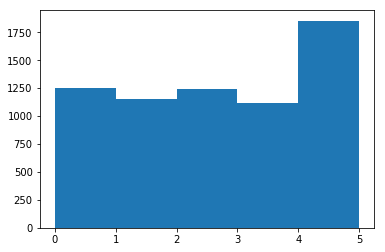

Done.


In [32]:
print('\nloading data ...')

# TODO: specific the directory of the csv files 
dir_path = 'data/'
filename = dir_path + 'test.csv'
X_test, y_test = load_data(filename)

filename = dir_path + 'train.csv'
X_train, y_train = load_data(filename, shuffle=True)

# split data into training and validation sets.
# 10% of the data is randomly chosen as validation set and 90% of the data is used for training.
X_train, y_train, X_val, y_val = split_data(X_train, y_train, 0.9)

# show number of samples per class
y = y_train.astype(int)
plt.hist(y.tolist(), range(min(y), max(y)+1))
plt.show()

print('Done.')

#### Replacing missing features

In [33]:
print('\nreplacing missing features ...')

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X_train)

X_train = imp.transform(X_train)
X_val = imp.transform(X_val)
X_test = imp.transform(X_test)

print('Done.')


replacing missing features ...
Done.


#### Data standardization
The goal of standardization is to rescale the features, so that they will have the properties of a standard normal distribution with $\mu = 0$ and $\sigma = 1$. The scaled features are calculated as follows:
$$z = \frac{x- \mu}{\sigma}$$, where $x$ is the unscaled feature and $z$ is the scaled feature.

In [34]:
print('\nstandardization ...')

std_scale = preprocessing.StandardScaler().fit(X_train)

X_train = std_scale.transform(X_train)
X_val = std_scale.transform(X_val)
X_test = std_scale.transform(X_test)

print('Done.')


standardization ...
Done.


### Reducing the dimensionality of features with PCA

In [8]:
def pca(X_train, X_test, n_components = 200):
    """
    Feature dimensionality reduction with PCA.
    :param X_train: training features
    :param X_test: test features
    :param n_components: number or principal ccomponents
    :return: dimensionality reduced training and test features
    """
    pca = PCA(n_components=n_components).fit(X_train)
    
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    return X_train, X_test

### Training an SVM and predicting the label of test data with the trained SVM

In [28]:
# In this function, I first train an SVM on the training data, i.e., X_train (features) and y_train (labels).
# Then the trained SVM is used to predict the labels for the test data.
def classification(X_train, y_train, X_test, y_test, grid_search=False):
    """
    Classification with SVM.
    :param X_train: training features
    :param y_train: training labels
    :param X_test: test features
    :param y_test: test labels
    :return: predicted labels, classification accuracy
    """

    print('training svm ...')
    clf = svm.SVC()

    if grid_search:
        param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
        clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)

    clf = clf.fit(X_train, y_train)

    print('predicting labels with svm ...')
    y_pred = clf.predict(X_test)

    acc = np.sum(y_test == y_pred) / len(y_test)

    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

    return y_pred, acc


# This function first applies dimension reduction on the features with PCA.
# Then it trains an SVM on the training data.
# Finally it predict the labels of the test data with the trained SVM.
def classification_pca(X_train, y_train, X_test, y_test, n_components, grid_search=False):
    """
    Classification with SVM
    :param X_train: training features
    :param y_train: training labels
    :param X_test: test features
    :param y_test: test labels
    :param n_components: number of components
    :return: predicted labels, classification accuracy
    """
    X_train_pca, X_test_pca = pca(X_train, X_test, n_components)

    y_pred, acc = classification(X_train_pca, y_train, X_test_pca, y_test, grid_search)

    return y_pred, acc

### Finding optimal number of principla components for the classification

The goal of this function is to get the optimal number of principal components in a given list.
To find an optimal number of components, each number of components in a given list is used to reduce the dimensionality of the features. Then the dimension reduced features with the labels are used to train an SVM. 
The SVM is used to predict the labels of the validation data where the dimension of its features are also reduced with the PCA of the specified number of components. The number of components which achieves highest classification accuracy is considered as the optimal number of principal components.

In [10]:
def get_n_components(X_train, y_train, X_val, y_val, n_components_list = [10, 50, 100, 200, 300]):
    """
    Find optimal number of components of PCA.
    :param X_train: training features
    :param y_train: training labels
    :param X_val: validation features
    :param y_val: validation labels
    :param n_components_list: a list contains the number of components of PCA
    :return: the optimal number of components in the given list.
    """
    best_acc = 0
    best_n_components = 0
    acc_list = []
    for n_components in n_components_list:
        y_pred, acc = classification_pca(X_train, y_train, X_val, y_val, n_components)
        acc_list.append(acc)
        print("number of components = %d accuracy = %f" % (n_components, acc))
        if acc > best_acc:
            best_acc = acc
            best_n_components = n_components

    plt.plot(n_components_list, acc_list)
    plt.show()

    return best_n_components

## Predicting label of test data with all the given features

In [35]:
print('\nevaluation ...')

y_pred, acc = classification(X_train, y_train, X_test, y_test, grid_search=False)

print("accuracy on test set (all features): %f " % acc)

print('Done.')


evaluation ...
training svm ...
predicting labels with svm ...
(2947,)
             precision    recall  f1-score   support

          0       0.99      1.00      1.00       537
          1       0.70      0.48      0.57       491
          2       0.63      0.81      0.71       532
          3       0.93      0.98      0.95       496
          4       0.98      0.88      0.93       420
          5       0.91      0.95      0.93       471

avg / total       0.85      0.85      0.85      2947

[[537   0   0   0   0   0]
 [  3 235 252   0   0   1]
 [  0  99 433   0   0   0]
 [  0   0   0 487   5   4]
 [  0   0   0  15 368  37]
 [  0   0   0  23   1 447]]
accuracy on test set (all features): 0.850696 
Done.


## Predicting label of test data with dimensionality reduced features by applying PCA


searching optimal number of principal components ...
training svm ...
predicting labels with svm ...
(736,)
             precision    recall  f1-score   support

          0       0.95      0.92      0.93       153
          1       0.85      0.62      0.72       133
          2       0.77      0.89      0.83       133
          3       0.98      0.91      0.94       111
          4       0.70      1.00      0.82        95
          5       1.00      0.88      0.94       111

avg / total       0.88      0.86      0.86       736

[[140   4   0   0   9   0]
 [  7  83  35   0   8   0]
 [  0  11 119   0   3   0]
 [  0   0   0 101  10   0]
 [  0   0   0   0  95   0]
 [  0   0   0   2  11  98]]
number of components = 10 accuracy = 0.864130
training svm ...
predicting labels with svm ...
(736,)
             precision    recall  f1-score   support

          0       0.99      0.91      0.95       153
          1       0.94      0.79      0.86       133
          2       0.87      0.92      0.

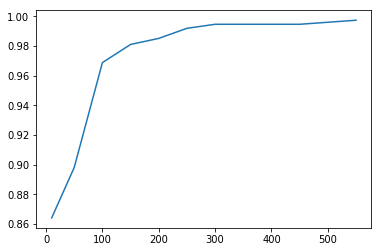

optimal number of components: 550 

evaluation ...
training svm ...
predicting labels with svm ...
(2947,)
             precision    recall  f1-score   support

          0       0.99      1.00      1.00       537
          1       0.70      0.48      0.57       491
          2       0.63      0.81      0.71       532
          3       0.93      0.98      0.95       496
          4       0.98      0.87      0.93       420
          5       0.91      0.95      0.93       471

avg / total       0.85      0.85      0.85      2947

[[537   0   0   0   0   0]
 [  3 234 253   0   0   1]
 [  0  99 433   0   0   0]
 [  0   0   0 487   5   4]
 [  0   0   0  15 367  38]
 [  0   0   0  22   1 448]]
accuracy on test set (PCA): 0.850356 
Done.


In [36]:
print('\nsearching optimal number of principal components ...')

n_components_list = [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550]

n_components = get_n_components(X_train, y_train, X_val, y_val, n_components_list)

print("optimal number of components: %d " % n_components)

print('\nevaluation ...')

y_pred, acc = classification_pca(X_train, y_train, X_test, y_test, n_components, grid_search=False)

print("accuracy on test set (PCA): %f " % acc)

print('Done.')


## Improving classification by relabeling ambiguous data (Failed)

The main goal is to relabel the data in the classes which is difficult to be correctly predicted. It can be seen that the data with label 1 and label 2 is difficult to be separated. Therefore, in order to separate the two classes, I train an SVM only on the data of the two classes. Then an SVM is used to relabel the test data which has the predicted label of 1 or 2 from the previous step. However, the proposed method does not achieve expected results. I expect that in the previous section, the principla compoenents selected by the PCA are suitable to separate the 5 classes. However, these components (features) are not good enough to separate the data from classes 1 and 2. Therefore, I try to select the optimal components (features) to seperate data from classes 1 and 2 with the same method presented in the previous section. However, the features are not discriminative enough to separate the data from classes 1 and 2.

In [ ]:
print('Relabeling ...')

# This function selects the data whose ground truth label is in a given label list.
def get_train_data(X, y, labels=[]):
    """
    Select data has the label in a given label list.
    :param X: features
    :param y: labels
    :param labels: a label list
    :return: selected data
    """
    X_sub = []
    y_sub = []
    for i in range(len(X)):
        if int(y[i]) in labels:
            X_sub.append(X[i])
            y_sub.append(y[i])
    return np.array(X_sub), np.array(y_sub)

# This function select the data whose predicted label is in a given label list.
def get_test_data(X_test, y_test, y_pred, labels=[]):
    """
    Select data has the predicted label in a given label list.
    :param X_test: features
    :param y_test: ground truth labels
    :param y_pred: predicted labels
    :param labels: a label list
    :return: selected data
    """
    X_sub = []
    y_sub = []
    for i in range(len(X_test)):
        if int(y_pred[i]) in labels:
            X_sub.append(X_test[i])
            y_sub.append(y_test[i])
    return np.array(X_sub), np.array(y_sub)


sub_labels = [1, 2]

# get a sub class of data in order to train a classifier to separate the data in the sub class.
X_train_sub, y_train_sub = get_train_data(X_train, y_train, sub_labels)

# split the sub class data into training and validation sets.
X_train_sub, y_train_sub, X_val_sub, y_val_sub = split_data(X_train_sub, y_train_sub, 0.1)

# get a sub class of test data whose predicted labels from the previous step are in [1, 2]
X_test_sub, y_test_sub = get_test_data(X_test, y_test, y_pred, sub_labels)

# find optimal number of principla components
n_components = get_n_components(X_train_sub, y_train_sub, X_val_sub, y_val_sub, n_components_list)
print('optimal number of components: %d' % n_components)

# relabel the test data of the sub class
y_pred_sub, acc = classification_pca(X_train_sub, y_train_sub, X_test_sub, y_test_sub, n_components, grid_search=False)


print("accuracy on sub test set (PCA): %f " % acc)

# evaluation the whole test set
y_test_all = []
y_pred_all = []

for i in range(len(y_pred)):
    if int(y_pred[i]) not in sub_labels:
        y_test_all.append(y_test[i])
        y_pred_all.append(y_pred[i])

for i in range(len(y_pred_sub)):
    y_test_all.append(y_test_sub[i])
    y_pred_all.append(y_pred_sub[i])

y_test_all = np.array(y_test_all)
y_pred_all = np.array(y_pred_all)

acc = np.sum(y_test_all == y_pred_all) / len(y_test_all)

print(classification_report(y_test_all, y_pred_all))
print(confusion_matrix(y_test_all, y_pred_all))
print("accuracy on test set (relabeling): %f " % acc)

print('Done.')


## Conclusion

This script shows one solution of predicting the label of unseen data (test data) by using machine learning methods. The data is cleaned by converting string values to integer values, replacing missing value with the mean of the column, and standardization. With an SVM, trained on the given features, I achieve about 92% classification accuracy. In order to reduce the dimensionality of the features, PCA is applied. I show that by applying a optimal number of principal components searching method, with 500 features, I achieve comparable performance compared to using all the features. While the original feature size is 564. I also find that the data from class 1 and class 2 is similar. The given features are not discriminative enough to separate the two classes. Therefore, one future work is to discover more discriminative features in order to separated the two classes. Collecting more training data may also increase the performance of the classification. 